In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import PrecisionRecallDisplay, confusion_matrix

# Import models
from tensorflow import keras
from keras import models, layers, activations, losses, optimizers, metrics
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import matplotlib.pyplot as plt

keras.utils.set_random_seed(42)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-10-24 20:03:02.159485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../data/all_data.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283726 entries, 0 to 283725
Data columns (total 31 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   X1       283726 non-null  float64
 1   X2       283726 non-null  float64
 2   X3       283726 non-null  float64
 3   X4       283726 non-null  float64
 4   X5       283726 non-null  float64
 5   X6       283726 non-null  float64
 6   X7       283726 non-null  float64
 7   X8       283726 non-null  float64
 8   X9       283726 non-null  float64
 9   X10      283726 non-null  float64
 10  X11      283726 non-null  float64
 11  X12      283726 non-null  float64
 12  X13      283726 non-null  float64
 13  X14      283726 non-null  float64
 14  X15      283726 non-null  float64
 15  X16      283726 non-null  float64
 16  X17      283726 non-null  float64
 17  X18      283726 non-null  float64
 18  X19      283726 non-null  float64
 19  X20      283726 non-null  float64
 20  X21      283726 non-null  

In [3]:
X = df.drop(['anomaly'], axis = 1)
y = df['anomaly']

In [4]:
X_scaled = MinMaxScaler().fit_transform(X) 
X_scaled = pd.DataFrame(X_scaled)
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
0,283726.0,0.182568,0.035081,0.0,0.161195,0.180393,0.201667,1.0
1,283726.0,0.418442,0.088580,0.0,0.368106,0.426569,0.482681,1.0
2,283726.0,0.544509,0.078182,0.0,0.499004,0.551049,0.597137,1.0
3,283726.0,0.698750,0.067850,0.0,0.654943,0.698256,0.743342,1.0
4,283726.0,0.696776,0.066746,0.0,0.649370,0.692590,0.739898,1.0
5,283726.0,0.745639,0.052603,0.0,0.718022,0.748848,0.777741,1.0
6,283726.0,0.744354,0.052478,0.0,0.716936,0.744186,0.774764,1.0
7,283726.0,0.729613,0.050701,0.0,0.695629,0.730888,0.764269,1.0
8,283726.0,0.360042,0.070805,0.0,0.316150,0.359067,0.404103,1.0
9,283726.0,0.721396,0.044752,0.0,0.706427,0.728932,0.748324,1.0


In [5]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
pca_X = pca.fit_transform(X_scaled)

[0.1546359  0.12070382]


In [6]:
pca_df = pd.DataFrame(pca_X, columns = ['component_1', 'component_2'])
pca_df['is_anomaly'] = y
pca_df = pca_df.sort_values(by=['is_anomaly'])
display(pca_df)

,component_1,component_2,is_anomaly
0,0.020043,-0.003269,0
189091,-0.202627,0.025098,0
189092,-0.061538,0.034067,0
189093,0.070425,-0.007448,0
189094,-0.250071,0.005326,0
...,...,...,...
191982,-0.028385,-0.074670,1
70319,-0.067055,-0.122888,1
43908,0.004109,-0.030460,1
99129,-0.034277,0.147021,1


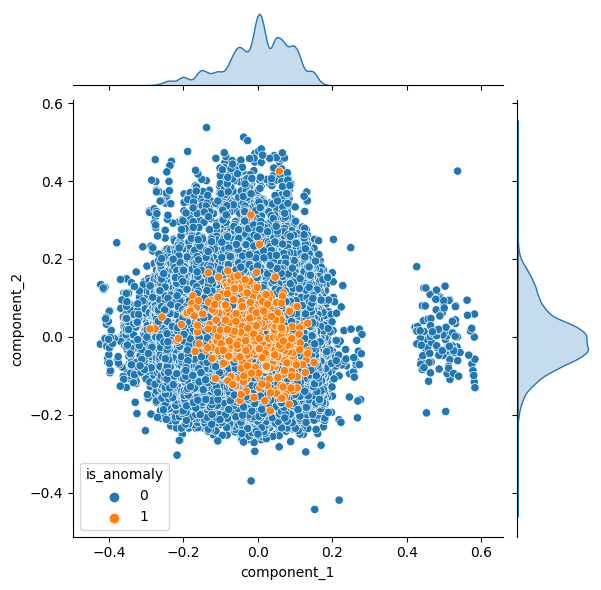

In [7]:
# Scatter plot of 2 features
sns.jointplot(data = pca_df, x="component_1", y="component_2", hue = "is_anomaly", kind='scatter')

In [8]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=df['anomaly'])

print(y_train.value_counts())
print(y_test.value_counts())

anomaly
0    226602
1       378
Name: count, dtype: int64
anomaly
0    56651
1       95
Name: count, dtype: int64


[[54923  1728]
 [   19    76]]


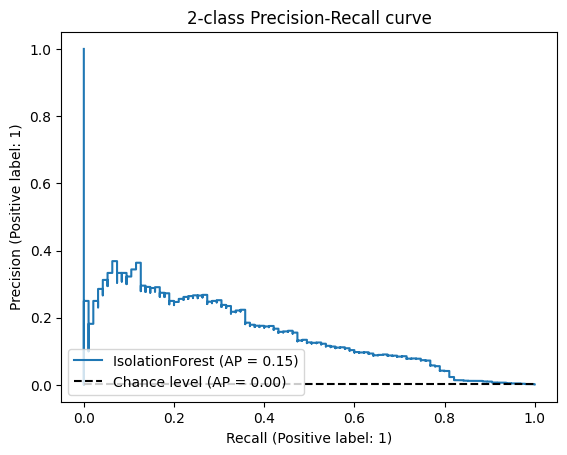

In [9]:
clf = IsolationForest(random_state=42).fit(X_train)

y_test_pred = clf.predict(X_test) * -1
y_test_pred[y_test_pred == -1] = 0
print(confusion_matrix(y_test, y_test_pred))

y_score = clf.decision_function(X_test) * -1

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="IsolationForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

[[52474  4177]
 [   85    10]]


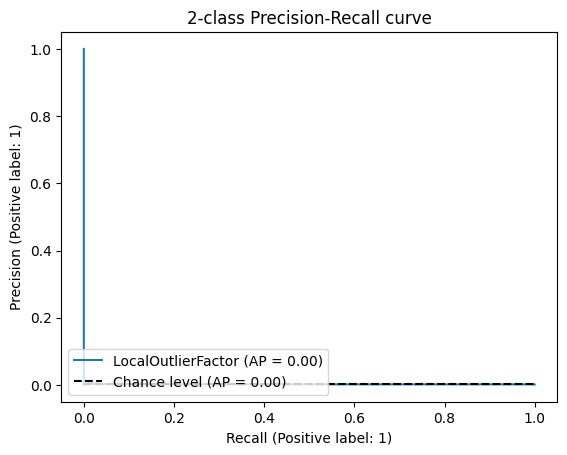

In [10]:
# define outlier detection model
clf = LocalOutlierFactor(novelty=True).fit(X_train)

y_test_pred = clf.predict(X_test) * -1
y_test_pred[y_test_pred == -1] = 0
print(confusion_matrix(y_test, y_test_pred))

y_score = clf.decision_function(X_test) * -1

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="LocalOutlierFactor", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

[[56650     1]
 [   25    70]]


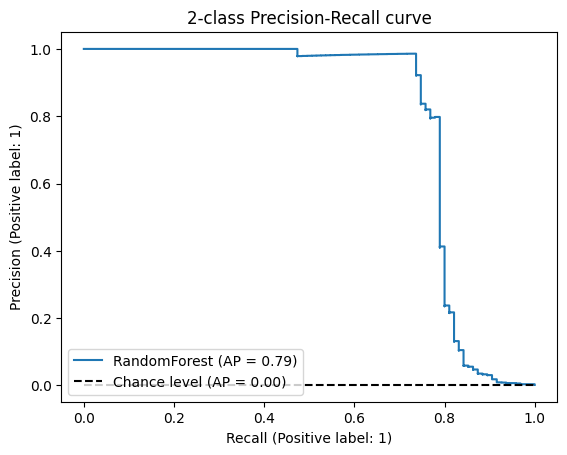

In [11]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state=42).fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

y_score = clf.predict_proba(X_test)[:,1]

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="RandomForest", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [12]:
clf = OneClassSVM(gamma='scale', nu=0.002)

[[222773   3829]
 [   207    171]]
171
226809
(226980, 30)
226809
(226809, 30)
(226809,)
[[222675   3927]
 [   134     73]]
73
226736
(226809, 30)
226736
(226736, 30)
(226736,)
[[222617   3985]
 [   119     15]]
15
226721
(226736, 30)
226721
(226721, 30)
(226721,)


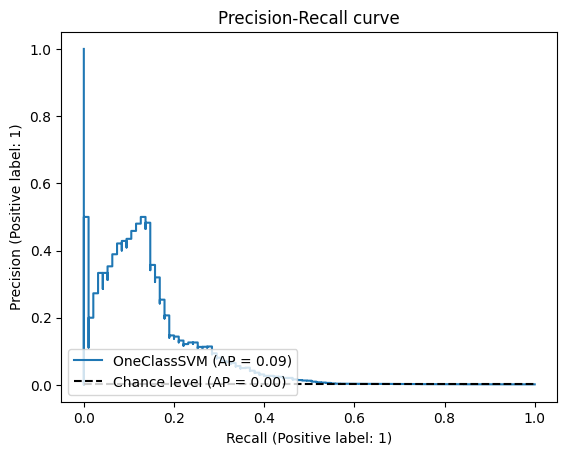

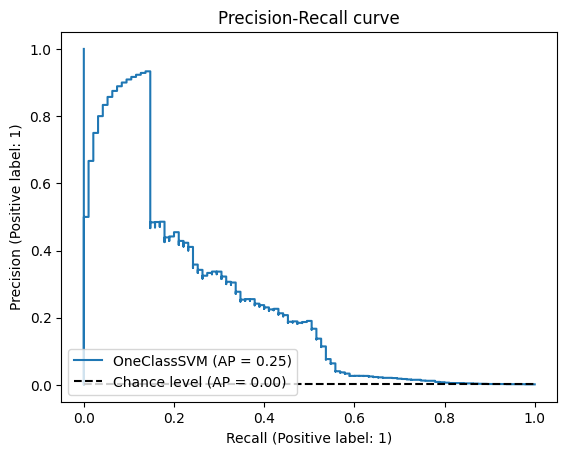

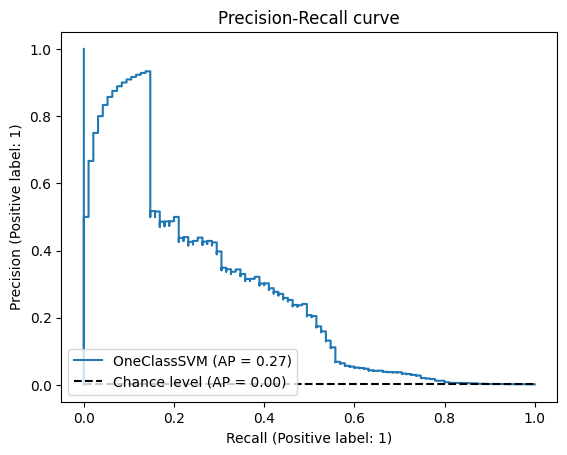

In [13]:
n_vec = [4000, 4000, 4000]

for i in range(3):

    clf.fit(X_train)
    
    y_score = clf.decision_function(X_test) * -1

    display = PrecisionRecallDisplay.from_predictions(
        y_test, y_score, name="OneClassSVM", plot_chance_level=True
    )
    _ = display.ax_.set_title("Precision-Recall curve")
    
    y_score = clf.decision_function(X_train) * -1
    
    y_train_pred = np.array([0] * len(y_train))
    y_train_pred[np.argsort(y_score)[-n_vec[i]:]] = 1
    print(confusion_matrix(y_train, y_train_pred))
    print(len(np.where((y_train == y_train_pred) & (y_train_pred == 1))[0]))
    print(len(np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]))
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    print(X_train.shape)
    retain_index = np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]
    print(len(retain_index))
    X_train = X_train.iloc[retain_index, :]
    y_train = y_train[retain_index]
    print(X_train.shape)
    print(y_train.shape)
    

In [14]:
X_train_normals = X_train[y_train == 0]
X_train_normals.shape

(226602, 30)

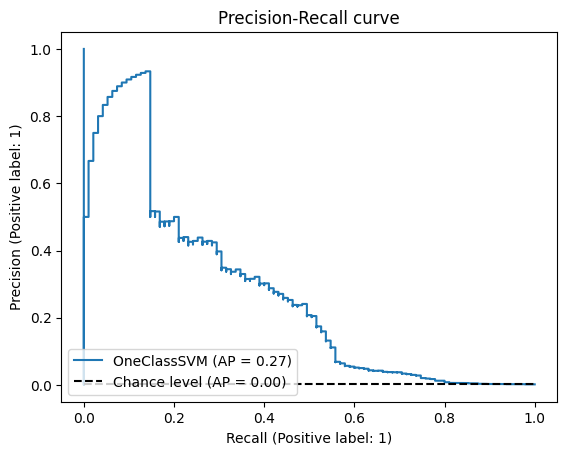

In [15]:
clf.fit(X_train_normals)
    
y_score = clf.decision_function(X_test) * -1

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="OneClassSVM", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [26]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=df['anomaly'])

print(y_train.value_counts())
print(y_test.value_counts())

anomaly
0    226602
1       378
Name: count, dtype: int64
anomaly
0    56651
1       95
Name: count, dtype: int64


In [27]:
n_features = 30

# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=n_features, activation='relu', input_shape=(n_features,)))
encoder.add(layers.Dropout(0.2))
encoder.add(layer=layers.Dense(units=16, activation='relu'))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=16, activation='relu', input_shape=(16,)))
decoder.add(layers.Dropout(0.2))
decoder.add(layer=layers.Dense(units=30, activation='relu'))
decoder.add(layers.Dropout(0.2))
decoder.add(layer=layers.Dense(units=n_features, activation='sigmoid'))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(
    loss=losses.mean_squared_error,
    optimizer=optimizers.Adam(),
    metrics=[metrics.mean_squared_error])

autoencoder.save_weights('init.h5')

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                496       
                                                                 
Total params: 1426 (5.57 KB)
Trainable params: 1426 (5.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 drop

In [28]:
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)

Epoch 1/50
7094/7094 [==============================] - 12s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/50
7094/7094 [==============================] - 11s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.9813e-04 - val_mean_squared_error: 9.9813e-04
Epoch 3/50
7094/7094 [==============================] - 13s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.8715e-04 - val_mean_squared_error: 9.8715e-04
Epoch 4/50
7094/7094 [==============================] - 14s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 9.8712e-04 - val_mean_squared_error: 9.8712e-04
Epoch 5/50
7094/7094 [==============================] - 17s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.9271e-04 - val_mean_squared_error: 9.9271e-04
Epoch 6/50
7094/7094 [==============================] - 16s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 9.7273e-04 - val_m

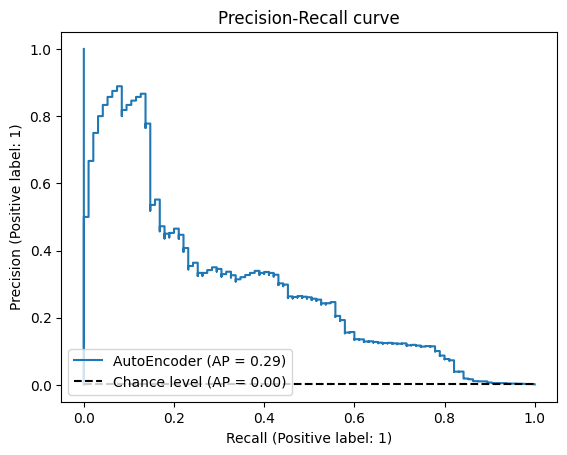

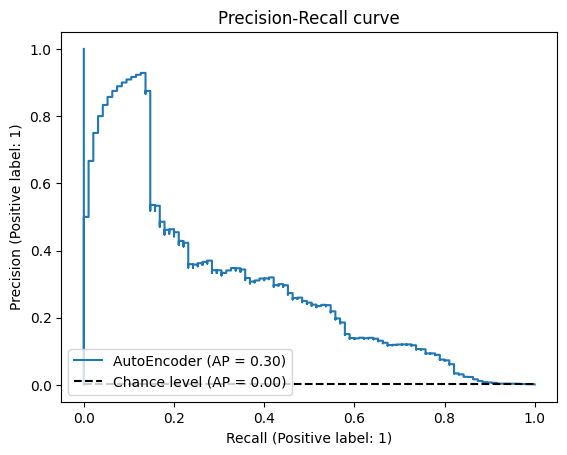

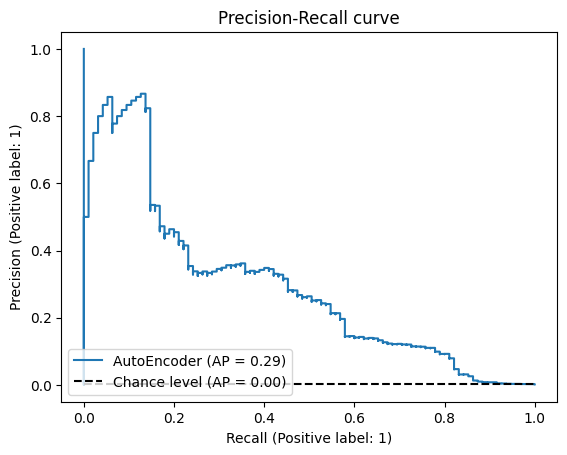

In [29]:
n_vec = [4000, 4000, 4000]

for i in range(3):
    
    autoencoder.load_weights('init.h5')

    history = autoencoder.fit(x=X_train, y=X_train, epochs=50, 
                          batch_size=32, shuffle=True, verbose=1, 
                          validation_data=(X_train, X_train), 
                          callbacks=[es])
    
    predicted_test = autoencoder.predict(x=X_test)

    y_score = losses.mean_squared_error(predicted_test, X_test)

    display = PrecisionRecallDisplay.from_predictions(
        y_test, y_score, name="AutoEncoder", plot_chance_level=True
    )
    _ = display.ax_.set_title("Precision-Recall curve")
    
    predicted_train = autoencoder.predict(x=X_train)

    y_score = losses.mean_squared_error(predicted_train, X_train)
    
    y_train_pred = np.array([0] * len(y_train))
    y_train_pred[np.argsort(y_score)[-n_vec[i]:]] = 1
    print(confusion_matrix(y_train, y_train_pred))
    print(len(np.where((y_train == y_train_pred) & (y_train_pred == 1))[0]))
    print(len(np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]))
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    print(X_train.shape)
    retain_index = np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]
    print(len(retain_index))
    X_train = X_train.iloc[retain_index, :]
    y_train = y_train[retain_index]
    print(X_train.shape)
    print(y_train.shape)
    

In [30]:
X_train_normals = X_train[y_train == 0]
X_train_normals.shape

(226602, 30)

Epoch 1/20
7082/7082 [==============================] - 16s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/20
7082/7082 [==============================] - 16s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/20
7082/7082 [==============================] - 15s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 4/20
7082/7082 [==============================] - 14s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/20
7082/7082 [==============================] - 17s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/20
7082/7082 [==============================] - 20s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 7/20

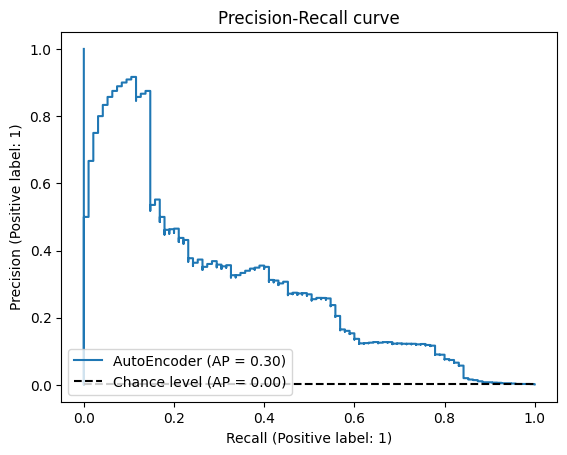

In [31]:
autoencoder.load_weights('init.h5')

es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)

history = autoencoder.fit(x=X_train_normals, y=X_train_normals, epochs=50, 
                      batch_size=32, shuffle=True, verbose=1, 
                      validation_data=(X_train_normals, X_train_normals), 
                      callbacks=[es])

predicted_test = autoencoder.predict(x=X_test)

y_score = losses.mean_squared_error(predicted_test, X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="AutoEncoder", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [22]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, 
                                                    random_state=42, stratify=df['anomaly'])

print(y_train.value_counts())
print(y_test.value_counts())

anomaly
0    226602
1       378
Name: count, dtype: int64
anomaly
0    56651
1       95
Name: count, dtype: int64


[[222711   3891]
 [   269    109]]
109
226871
(226980, 30)
226871
(226871, 30)
(226871,)
[[222792   3810]
 [    79    190]]
190
226681
(226871, 30)
226681
(226681, 30)
(226681,)
[[222611   3991]
 [    70      9]]
9
226672
(226681, 30)
226672
(226672, 30)
(226672,)


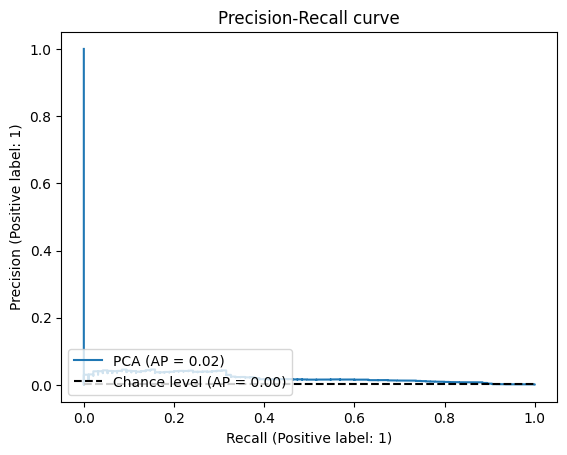

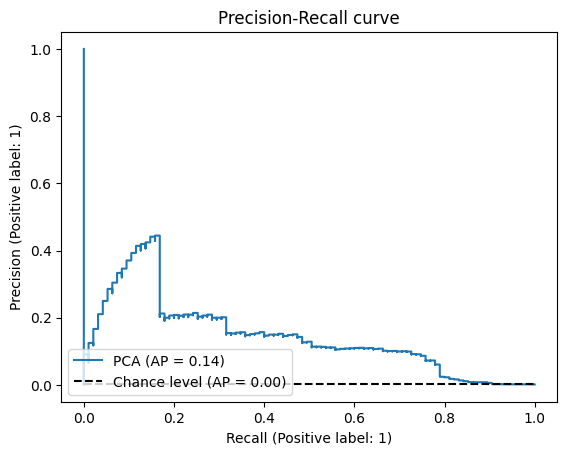

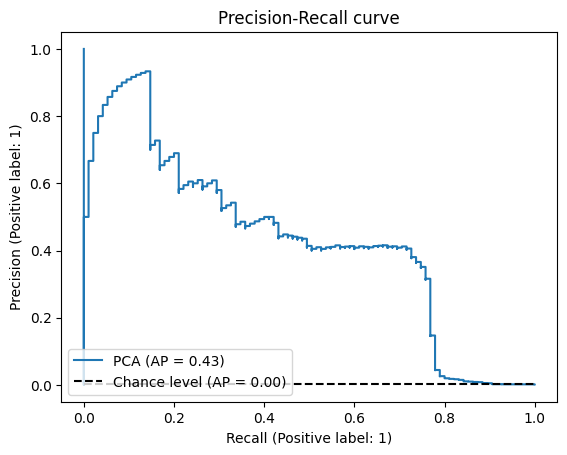

In [23]:
n_vec = [4000, 4000, 4000]

for i in range(3):
    
    pca = PCA(n_components=20, random_state=42)
    pca_train = pd.DataFrame(pca.fit_transform(X_train))
    pca_test = pd.DataFrame(pca.transform(X_test))
    
    predicted_test = pd.DataFrame(pca.inverse_transform(pca_test))

    y_score = losses.mean_squared_error(predicted_test, X_test)

    display = PrecisionRecallDisplay.from_predictions(
        y_test, y_score, name="PCA", plot_chance_level=True
    )
    _ = display.ax_.set_title("Precision-Recall curve")
    
    predicted_train = pd.DataFrame(pca.inverse_transform(pca_train))

    y_score = losses.mean_squared_error(predicted_train, X_train)
    
    y_train_pred = np.array([0] * len(y_train))
    y_train_pred[np.argsort(y_score)[-n_vec[i]:]] = 1
    print(confusion_matrix(y_train, y_train_pred))
    print(len(np.where((y_train == y_train_pred) & (y_train_pred == 1))[0]))
    print(len(np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]))
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    print(X_train.shape)
    retain_index = np.where((y_train != y_train_pred) | (y_train_pred == 0))[0]
    print(len(retain_index))
    X_train = X_train.iloc[retain_index, :]
    y_train = y_train[retain_index]
    print(X_train.shape)
    print(y_train.shape)

In [24]:
X_train_normals = X_train[y_train == 0]
X_train_normals.shape

(226602, 30)

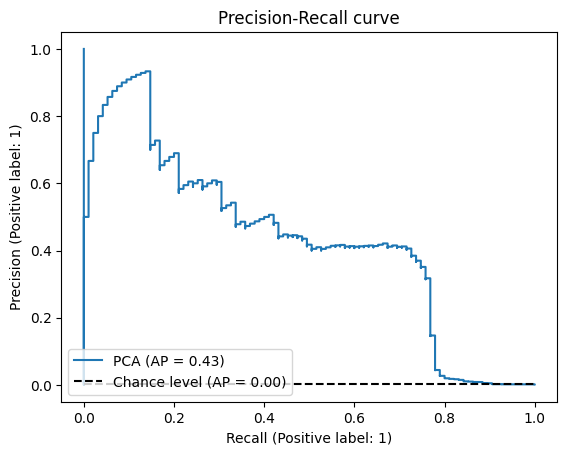

In [25]:
pca = PCA(n_components=20, random_state=42)
pca_train = pd.DataFrame(pca.fit_transform(X_train_normals))
pca_test = pd.DataFrame(pca.transform(X_test))

predicted_test = pd.DataFrame(pca.inverse_transform(pca_test))

y_score = losses.mean_squared_error(predicted_test, X_test)

display = PrecisionRecallDisplay.from_predictions(
    y_test, y_score, name="PCA", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")